In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.datasets import UPFD

## Check datasets

In [16]:
df = pd.read_csv("./datasets/politifact.csv")

df.head()

,Unnamed: 0,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article,curator_tags
0,0,Viral image,2021-03-20 00:00:00,a Facebook post:\n,\nSays Disneyland is enforcing a “no scream” p...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"\nNo, Disneyland isn’t enforcing a ‘no scream’...",\nBack in July a Japanese amusement park drew ...,"Facebook Fact-checks,Coronavirus,Viral image"
1,1,Viral image,2021-01-24 00:00:00,a Facebook post:\n,\nVideo “proves 100% that President Joe Biden ...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"\nNo, this video doesn’t prove Biden isn’t hum...",\nA recent Facebook post uses a video clip of ...,"Facebook Fact-checks,Viral image"
2,2,Terry McAuliffe,2021-03-10 00:00:00,a speech:\n,\n“If you look at the average teacher pay comp...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,\nVa. teachers pay ranks last in U.S. compared...,"\n""If you look at the average teacher pay comp...","Education,Income,Wealth,Virginia,Terry McAuliffe"
3,3,TikTok posts,2021-03-17 00:00:00,a video caption:\n,\n“You will need a WHO Yellow Vaccination Pass...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"\nNo, you don’t need a WHO vaccination certifi...",\nA popular TikTok video said that if you want...,"Facebook Fact-checks,Coronavirus,TikTok posts"
4,4,Mike Bost,2021-03-15 00:00:00,a radio,\nThe American Rescue Plan Act “does not” incl...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,\nDoes the American Rescue Plan limit how stat...,\nAfter failing to stop the $1.9 trillion COVI...,"Federal Budget,State Budget,Illinois,Coronavir..."


In [39]:
df.sources_quote[2], df.fact[2]

('\n“If you look at the average teacher pay compared to the average pay of your citizens, Virginia ranks last.”\n',
 'true')

In [33]:
df.sources_quote[1000], df.fact[1000], df.sources_post_location[1000]

('\nThe coronavirus pandemic is “effectively over” in the United Kingdom and “there is absolutely no need for vaccines.”\n',
 'false',
 ' a blog post:\n')

In [29]:
df.sources_quote.apply(lambda x: len(x)).sort_values(ascending=False)

4606     450
726      439
11929    402
17440    395
5720     393
        ... 
15696     14
18722     13
18914     13
13910     13
11094     13
Name: sources_quote, Length: 19422, dtype: int64

In [60]:
def dataset_stats(datasets: list):
    num_nodes = 0
    num_edges = 0
    num_graphs = sum([len(dataset) for dataset in datasets])
    num_fake = 0
    for dataset in datasets:
        for data in dataset:
            num_nodes += data.x.shape[0]
            num_edges += data.edge_index.shape[1]
            num_fake += data.y.item()
    avg_num_nodes = num_nodes / num_graphs
    return {'num_nodes': num_nodes, 'num_edges': num_edges, 'avg_num_nodes': avg_num_nodes, 'num_fake': num_fake, 'num_graphs': num_graphs}

In [2]:
train_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='train')
test_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='test')
val_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='val')

In [62]:
dataset_stats([train_dataset, test_dataset, val_dataset])

{'num_nodes': 41054,
 'num_edges': 40740,
 'avg_num_nodes': 130.74522292993632,
 'num_fake': 157,
 'num_graphs': 314}

In [4]:
train_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='train')
test_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='test')
val_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='val')

In [64]:
dataset_stats([train_dataset, test_dataset, val_dataset])

{'num_nodes': 314262,
 'num_edges': 308798,
 'avg_num_nodes': 57.515007320644216,
 'num_fake': 2732,
 'num_graphs': 5464}

In [54]:
train_dataset[0].y.item()

0

## Analysis of results

In [4]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [43]:
df_upfd = pd.read_csv('./results/upfdnet.csv')
df_single = pd.read_csv('./results/upfdsingle.csv')
df_multi = pd.read_csv('./results/multifeature.csv')
df_parallel = pd.read_csv('./results/parallelfeature.csv')

df_upfd.shape, df_single.shape, df_multi.shape, df_parallel.shape

((32, 13), (32, 13), (24, 13), (24, 13))

In [46]:
models = ['UPFD', 'UPFDSingle', 'MultiFeature', 'ParallelFeature']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1', 'ROC AUC']

upfd_politifact = []
upfd_gossipcop = []

In [62]:
names = ['politifact', 'gossipcop']
features = ['content', 'bert', 'profile', 'spacy']
conv_layers = ['gcn', 'sage', 'gat']
models = ['UPFD', 'UPFDSingle', 'MultiFeature', 'ParallelFeature']

In [72]:
upfd_df = pd.read_csv('./results/upfdnet.csv')
upfd_single_df = pd.read_csv('./results/upfdsingle.csv')

def create_performance_plots(df1, df2, metric, title_suffix):
    plt.figure(figsize=(15, 6))
    
    df1_grouped = df1.groupby(['feature', 'conv_layer'])[metric].mean().unstack()
    df2_grouped = df2.groupby(['feature', 'conv_layer'])[metric].mean().unstack()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(df1_grouped, annot=True, cmap="YlGnBu", fmt='.3f', ax=ax1)
    sns.heatmap(df2_grouped, annot=True, cmap="YlGnBu", fmt='.3f', ax=ax2)
    
    ax1.set_title(f'UPFD Network - {title_suffix}')
    ax2.set_title(f'UPFD Single - {title_suffix}')
    
    plt.tight_layout()
    return plt

def create_feature_comparison(df1, df2, metric):
    plt.figure(figsize=(12, 6))
    
    df1_mean = df1.groupby('feature')[metric].mean()
    df2_mean = df2.groupby('feature')[metric].mean()
    x = np.arange(len(df1_mean.index))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, df1_mean, width, label='UPFD Network')
    ax.bar(x + width/2, df2_mean, width, label='UPFD Single')
    
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'Average {metric.capitalize()} by Feature Type')
    ax.set_xticks(x)
    ax.set_xticklabels(df1_mean.index)
    ax.legend()
    
    plt.tight_layout()
    return plt

def analyze_dataset_performance(df1, df2):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = []
    
    for dataset in ['politifact', 'gossipcop']:
        for metric in metrics:
            upfd_score = df1[df1['name'] == dataset][metric].mean()
            single_score = df2[df2['name'] == dataset][metric].mean()
            results.append({
                'Dataset': dataset,
                'Metric': metric,
                'UPFD Network': upfd_score,
                'UPFD Single': single_score,
                'Difference': upfd_score - single_score
            })
    
    return pd.DataFrame(results)

metrics_to_plot = ['accuracy', 'f1', 'roc_auc']
for metric in metrics_to_plot:
    create_performance_plots(upfd_df, upfd_single_df, metric, f'{metric.upper()} Comparison')
    plt.savefig(f'heatmap_{metric}.png')
    plt.close()
    
    create_feature_comparison(upfd_df, upfd_single_df, metric)
    plt.savefig(f'feature_comparison_{metric}.png')
    plt.close()

performance_analysis = analyze_dataset_performance(upfd_df, upfd_single_df)

def get_best_configurations(df, metrics=['accuracy', 'f1', 'roc_auc']):
    best_configs = []
    
    for metric in metrics:
        best_idx = df[metric].idxmax()
        best_row = df.loc[best_idx]
        best_configs.append({
            'Metric': metric,
            'Best Score': best_row[metric],
            'Feature': best_row['feature'],
            'Conv Layer': best_row['conv_layer'],
            'Dataset': best_row['name']
        })
    
    return pd.DataFrame(best_configs)

upfd_best = get_best_configurations(upfd_df)
single_best = get_best_configurations(upfd_single_df)

print("\nPerformance Analysis by Dataset:")
print(performance_analysis.to_string())
print("\nBest Configurations - UPFD Network:")
print(upfd_best.to_string())
print("\nBest Configurations - UPFD Single:")
print(single_best.to_string())

def calculate_statistical_metrics(df1, df2):
    metrics = ['accuracy', 'f1', 'roc_auc']
    stats = []
    
    for metric in metrics:
        upfd_mean = df1[metric].mean()
        upfd_std = df1[metric].std()
        single_mean = df2[metric].mean()
        single_std = df2[metric].std()
        
        stats.append({
            'Metric': metric,
            'UPFD_Mean': upfd_mean,
            'UPFD_Std': upfd_std,
            'Single_Mean': single_mean,
            'Single_Std': single_std,
            'Mean_Difference': upfd_mean - single_mean
        })
    
    return pd.DataFrame(stats)

statistical_analysis = calculate_statistical_metrics(upfd_df, upfd_single_df)
print("\nStatistical Analysis:")
print(statistical_analysis.to_string())


Performance Analysis by Dataset:
      Dataset     Metric  UPFD Network  UPFD Single  Difference
0  politifact   accuracy      0.703243     0.721342   -0.018100
1  politifact  precision      0.708028     0.709972   -0.001943
2  politifact     recall      0.679941     0.572271    0.107670
3  politifact         f1      0.668121     0.600033    0.068088
4  politifact    roc_auc      0.703782     0.724793   -0.021011
5   gossipcop   accuracy      0.866048     0.645822    0.220226
6   gossipcop  precision      0.817602     0.439177    0.378426
7   gossipcop     recall      0.874522     0.373043    0.501479
8   gossipcop         f1      0.838824     0.391475    0.447349
9   gossipcop    roc_auc      0.866035     0.646251    0.219784

Best Configurations - UPFD Network:
     Metric  Best Score Feature Conv Layer    Dataset
0  accuracy    0.969681    bert        gat  gossipcop
1        f1    0.970026    bert        gat  gossipcop
2   roc_auc    0.969665    bert        gat  gossipcop

Best Con

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [5]:
def load_and_prepare_data(multifeature_path, parallelfeature_path):
    multi_df = pd.read_csv(multifeature_path)
    parallel_df = pd.read_csv(parallelfeature_path)
    
    multi_df['model_type'] = 'MultiFeature'
    parallel_df['model_type'] = 'ParallelFeature'
    combined_df = pd.concat([multi_df, parallel_df], ignore_index=True)    
    combined_df['feature'] = combined_df['feature'].apply(eval)
    
    return combined_df

def plot_performance_metrics(df, metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(15, 10))
    
    model_types = df['model_type'].unique()
    datasets = df['name'].unique()
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(len(datasets), n_metrics, figsize=(20, 8*len(datasets)))
    fig.suptitle('Performance Metrics Comparison', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(datasets):
        dataset_df = df[df['name'] == dataset]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            sns.boxplot(data=dataset_df, x='conv_layer', y=metric, hue='model_type', ax=ax)
            
            ax.set_title(f'{dataset} - {metric}')
            ax.set_xlabel('GNN Layer')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_feature_comparison(df):
    plt.figure(figsize=(15, 10))
    
    feature_combinations = df['feature'].apply(tuple).unique()
    
    metrics = ['accuracy', 'f1', 'roc_auc']
    fig, axes = plt.subplots(2, len(metrics), figsize=(20, 12))
    fig.suptitle('Feature Combination Performance Comparison', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(['politifact', 'gossipcop']):
        dataset_df = df[df['name'] == dataset]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            feature_performance = []
            for feat_combo in feature_combinations:
                feat_mask = dataset_df['feature'].apply(lambda x: tuple(sorted(x)) == tuple(sorted(feat_combo)))
                mean_perf = dataset_df[feat_mask][metric].mean()
                feature_performance.append({
                    'features': ' + '.join(feat_combo),
                    'performance': mean_perf
                })
            
            plot_df = pd.DataFrame(feature_performance)
            
            sns.barplot(data=plot_df, x='features', y='performance', ax=ax)
            ax.set_title(f'{dataset} - {metric}')
            ax.set_xlabel('Feature Combination')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_training_stability(df):
    plt.figure(figsize=(15, 10))
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Training Stability Analysis', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(['politifact', 'gossipcop']):
        dataset_df = df[df['name'] == dataset]
        
        ax1 = axes[i, 0]
        ax1.scatter(dataset_df['train_mean'], dataset_df['val_mean'], 
                   c=dataset_df['model_type'].map({'MultiFeature': 'blue', 'ParallelFeature': 'red'}),
                   alpha=0.6)
        ax1.set_xlabel('Training Mean')
        ax1.set_ylabel('Validation Mean')
        ax1.set_title(f'{dataset} - Train vs Validation Mean')
        
        min_val = min(dataset_df['train_mean'].min(), dataset_df['val_mean'].min())
        max_val = max(dataset_df['train_mean'].max(), dataset_df['val_mean'].max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        ax2 = axes[i, 1]
        ax2.scatter(dataset_df['train_std'], dataset_df['val_std'],
                   c=dataset_df['model_type'].map({'MultiFeature': 'blue', 'ParallelFeature': 'red'}),
                   alpha=0.6)
        ax2.set_xlabel('Training Std')
        ax2.set_ylabel('Validation Std')
        ax2.set_title(f'{dataset} - Train vs Validation Std')
        
        for ax in [ax1, ax2]:
            ax.legend(['Ideal', 'MultiFeature', 'ParallelFeature'])
    
    plt.tight_layout()
    return fig

def generate_summary_statistics(df):
    summary = []
    
    for dataset in df['name'].unique():
        dataset_df = df[df['name'] == dataset]
        
        for model in dataset_df['model_type'].unique():
            model_df = dataset_df[dataset_df['model_type'] == model]
            
            stats = {
                'Dataset': dataset,
                'Model': model,
                'Mean Accuracy': model_df['accuracy'].mean(),
                'Best Accuracy': model_df['accuracy'].max(),
                'Mean F1': model_df['f1'].mean(),
                'Best F1': model_df['f1'].max(),
                'Mean ROC-AUC': model_df['roc_auc'].mean(),
                'Best ROC-AUC': model_df['roc_auc'].max(),
                'Best Feature Combo': model_df.loc[model_df['accuracy'].idxmax(), 'feature'],
                'Best GNN Layer': model_df.loc[model_df['accuracy'].idxmax(), 'conv_layer']
            }
            summary.append(stats)
    
    return pd.DataFrame(summary)

def run_analysis(multifeature_path, parallelfeature_path, output_dir='./visual'):
    df = load_and_prepare_data(multifeature_path, parallelfeature_path)
    
    performance_fig = plot_performance_metrics(df)
    performance_fig.savefig(f'{output_dir}/performance_metrics.png', bbox_inches='tight', dpi=300)
    
    feature_fig = plot_feature_comparison(df)
    feature_fig.savefig(f'{output_dir}/feature_comparison.png', bbox_inches='tight', dpi=300)
    
    stability_fig = plot_training_stability(df)
    stability_fig.savefig(f'{output_dir}/training_stability.png', bbox_inches='tight', dpi=300)
    
    summary_stats = generate_summary_statistics(df)
    summary_stats.to_csv(f'{output_dir}/summary_statistics.csv', index=False)
    
    return df, summary_stats

<Figure size 1500x1000 with 0 Axes>

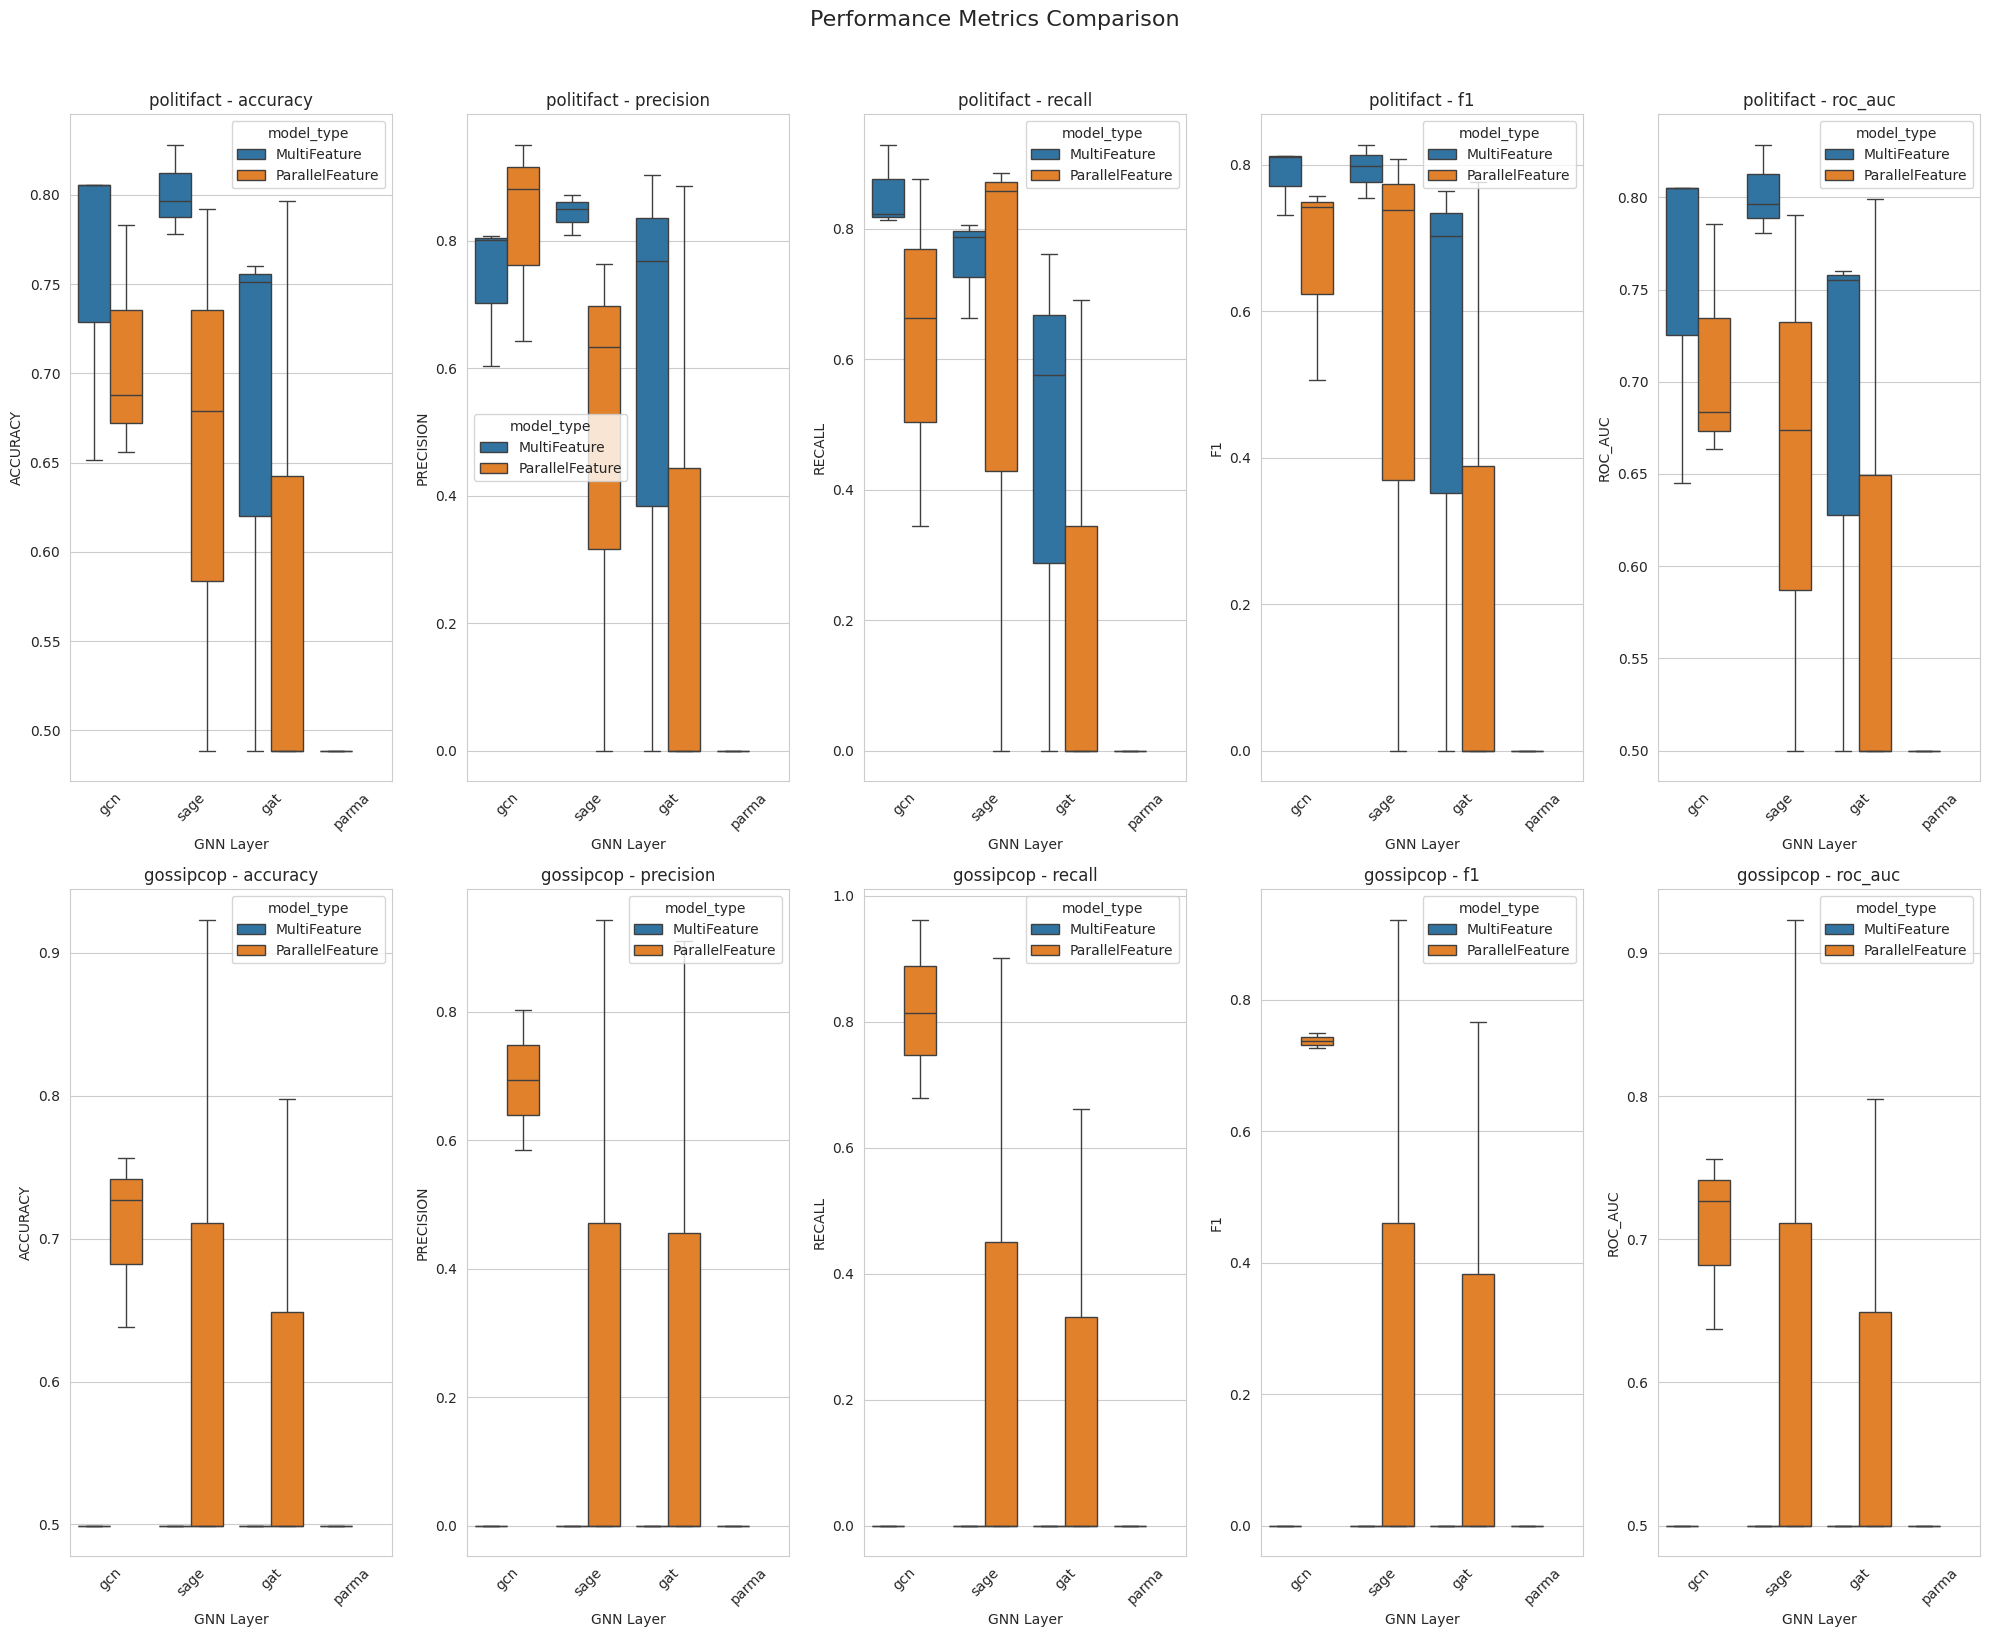

<Figure size 1500x1000 with 0 Axes>

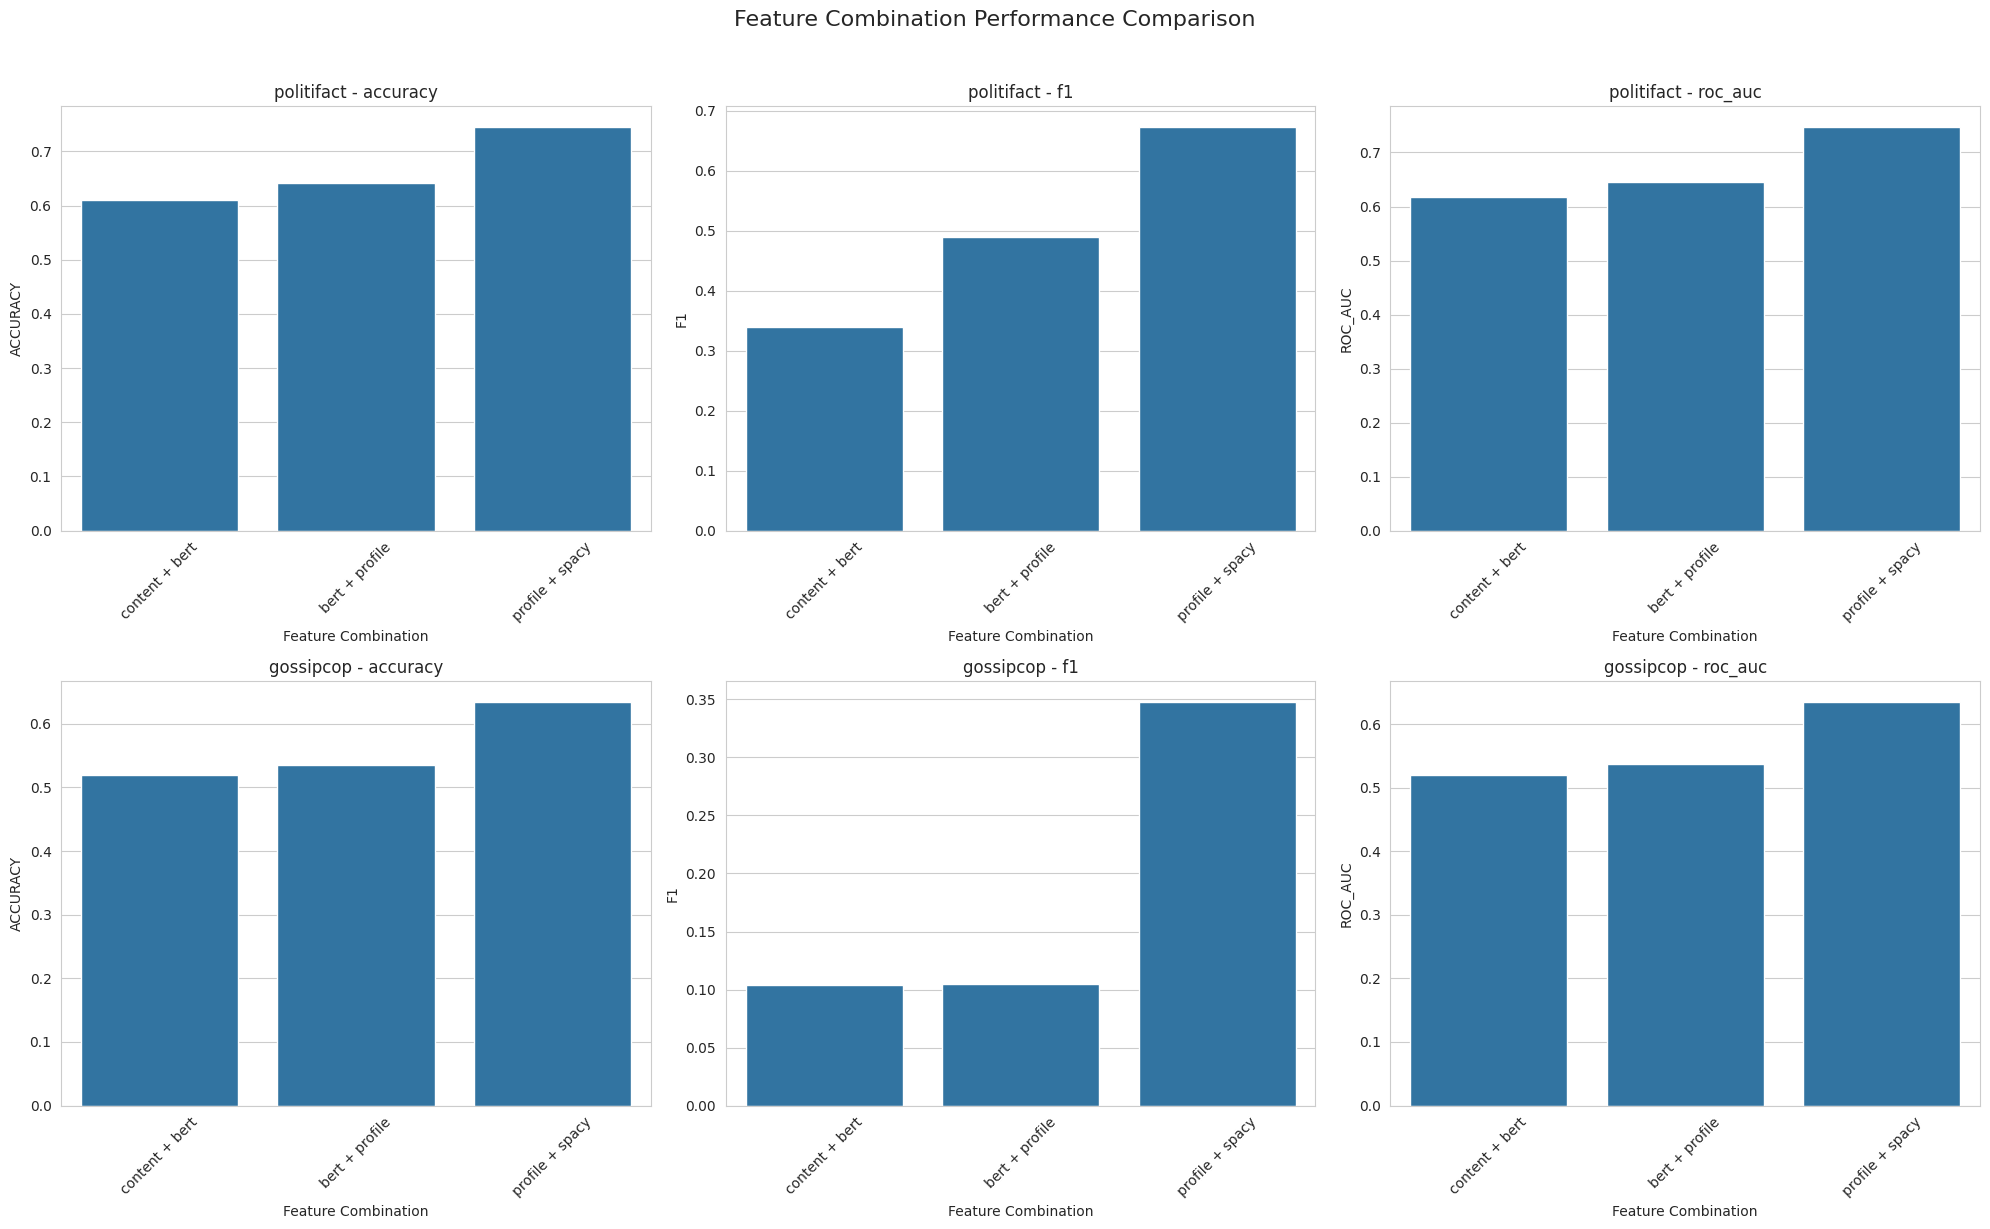

<Figure size 1500x1000 with 0 Axes>

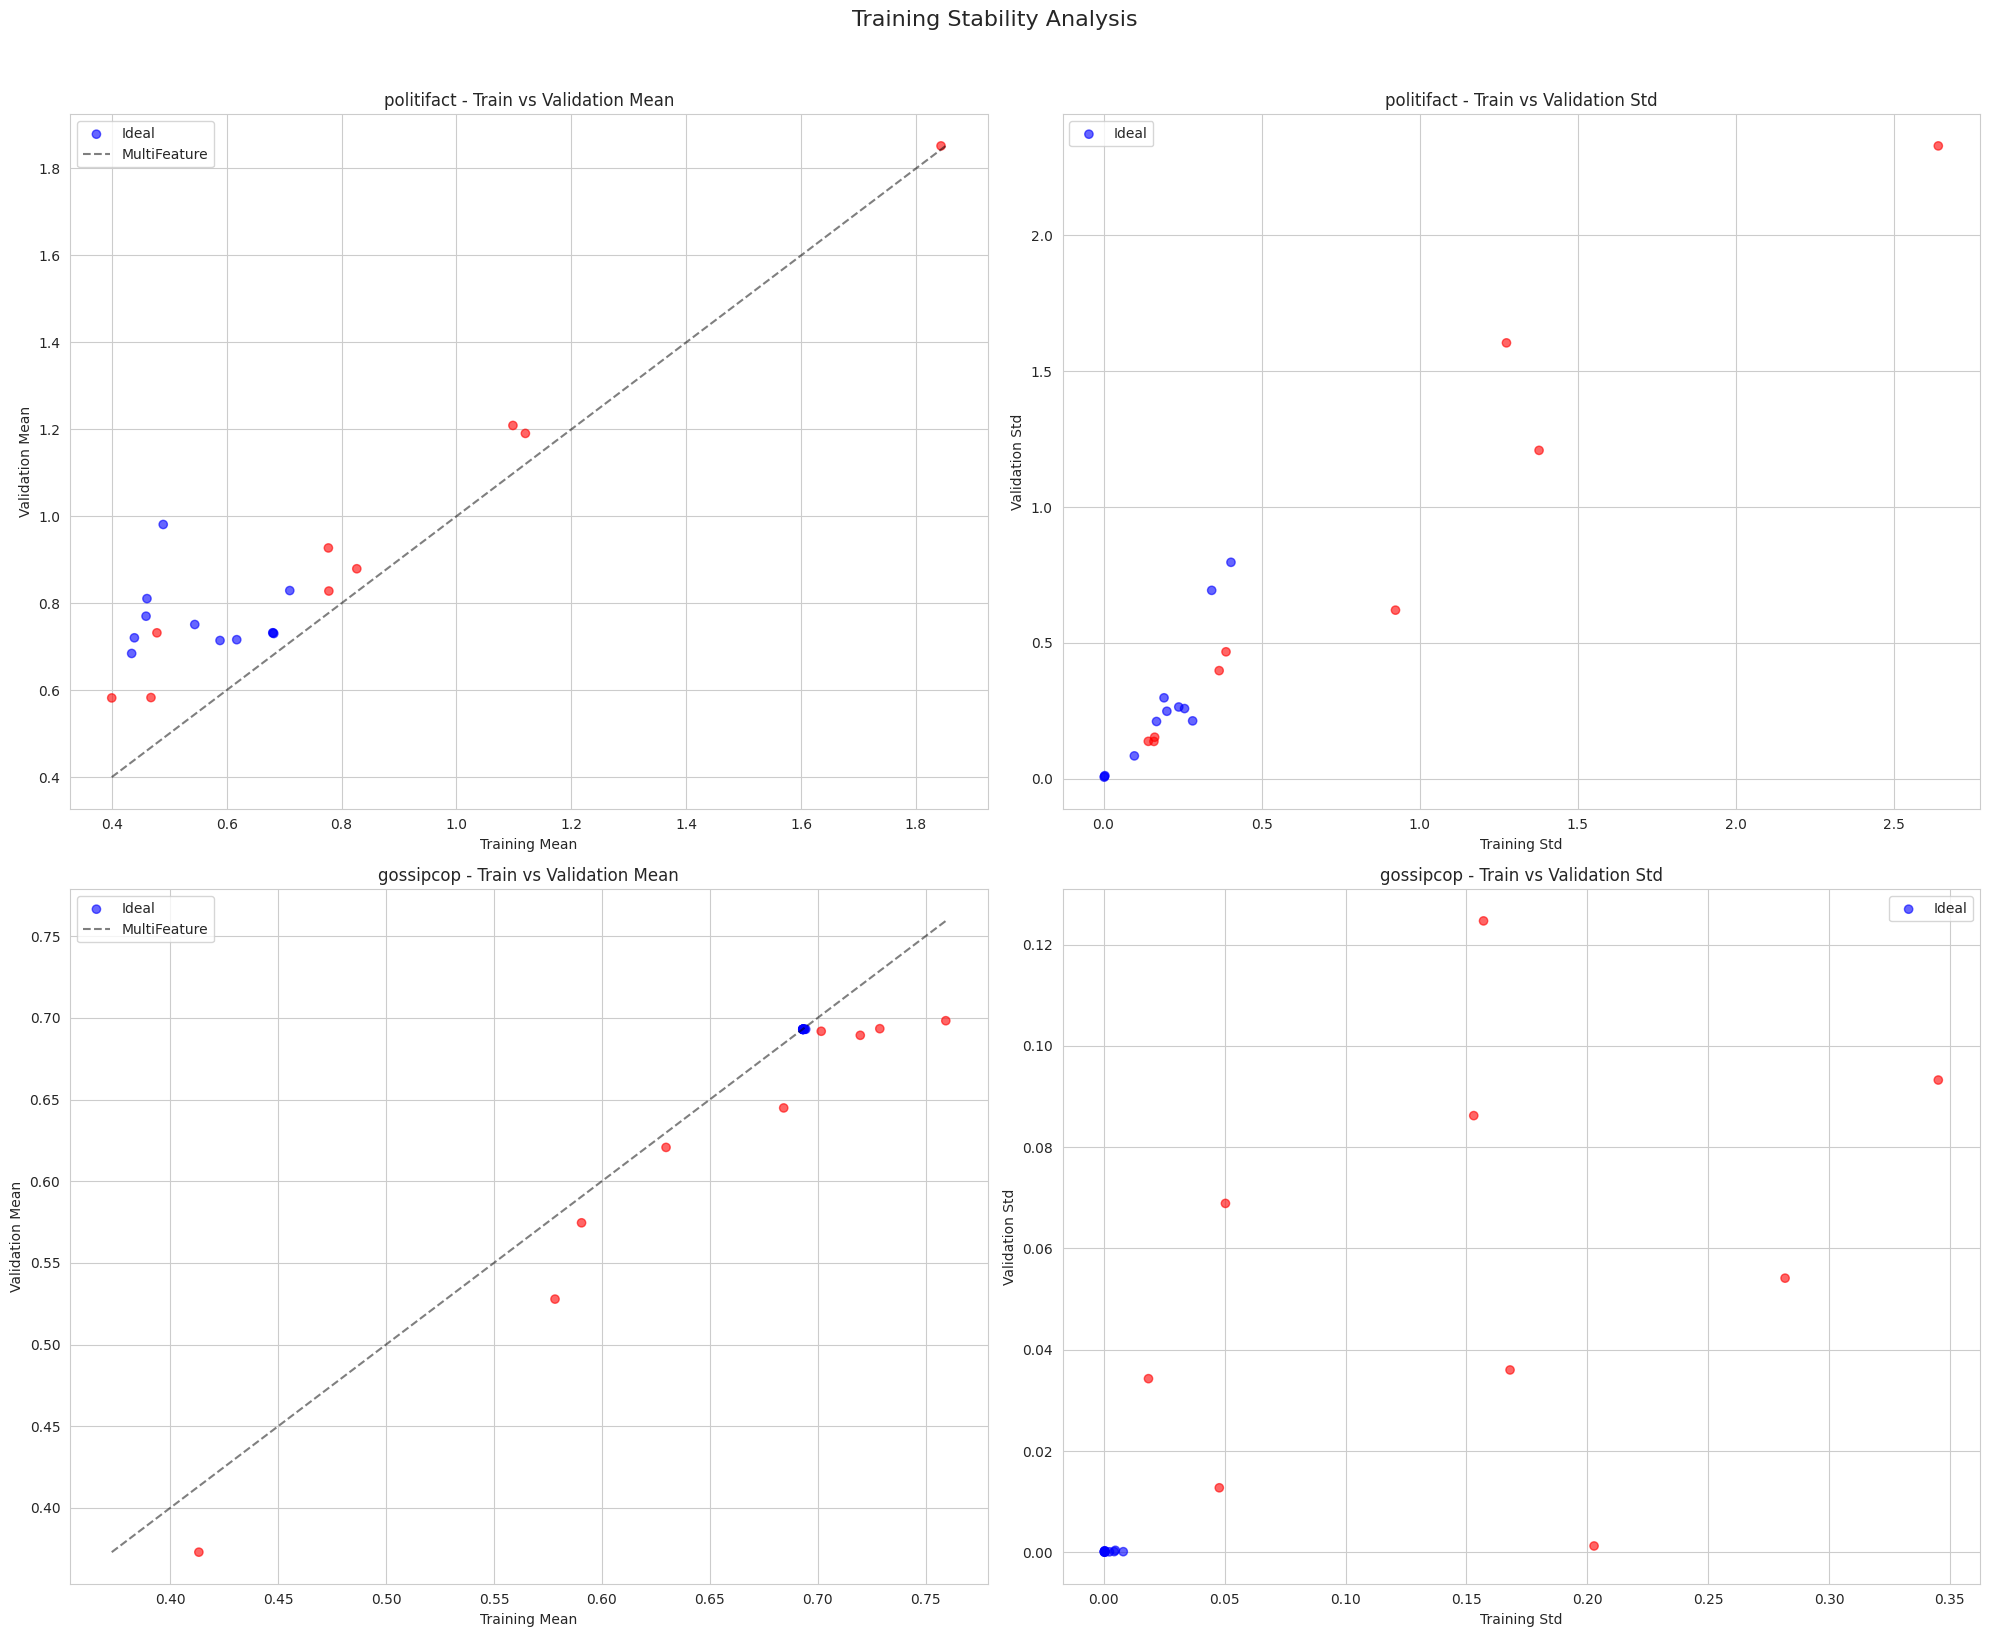

In [6]:
df, stats = run_analysis('./results/multifeature.csv', './results/parallelfeature.csv')

In [77]:
stats

,Dataset,Model,Mean Accuracy,Best Accuracy,Mean F1,Best F1,Mean ROC-AUC,Best ROC-AUC,Best Feature Combo,Best GNN Layer
0,politifact,MultiFeature,0.750126,0.819005,0.774800,0.819820,0.748552,0.819322,"[bert, profile]",gcn
1,politifact,ParallelFeature,0.651081,0.796380,0.480900,0.808333,0.655045,0.798836,"[profile, spacy]",gat
2,gossipcop,MultiFeature,0.499216,0.499216,0.000000,0.000000,0.500000,0.500000,"[content, bert]",gcn
3,gossipcop,ParallelFeature,0.648806,0.923157,0.433365,0.921516,0.649124,0.923192,"[profile, spacy]",sage
